# Machine Learning

## Clustering

In [1]:
import warnings
from zipfile import ZIP_DEFLATED

import numpy as np
import pandas as pd
import sklearn
from sklearn.base import BaseEstimator, OneToOneFeatureMixin, TransformerMixin, clone, is_clusterer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.exceptions import FitFailedWarning
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (r2_score, root_mean_squared_error,
                             silhouette_score, PredictionErrorDisplay)
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.utils.validation import check_is_fitted, validate_data
import matplotlib.pyplot as plt
import seaborn as sns
import skops.io as sio


warnings.filterwarnings('ignore', 'Creating legend with loc="best" can be slow')
pd.options.future.infer_string = True
pd.options.mode.copy_on_write = True
pd.options.display.max_columns = 40
sklearn.set_config(transform_output='pandas')
sns.set_theme()

train_data = pd.read_parquet("../data/train.parquet")
train_data.sample(5, random_state=123)

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
118117497,KIA,KIA,STONIC,1195.0,petrol,M,998.0,74.0,93,5.5
132182599,VOLKSWAGEN,SEAT,IBIZA,1178.0,petrol,M,999.0,81.0,207,5.4
128683065,BMW,MINI,COUNTRYMAN COOPER D,1585.0,diesel,M,1995.0,110.0,6,5.2
132679971,VOLKSWAGEN,VOLKSWAGEN,TAIGO,1261.0,petrol,M,999.0,81.0,207,5.9
122542786,STELLANTIS,PEUGEOT,2008,1280.0,petrol,M,1199.0,96.0,160,5.9


As stated in the first notebook, the scope of this project is to train machine learning models to help consumers predict fuel consumptions of passenger cars. Thus, it seems reasonable to start the analysis by clustering the data. This way, we can try to determine the main vehicle classes that the market offers, and the characteristics of those classes.

Moreover, clustering can also prove useful from a feature engineering perspective, as knowing the the vehicle class could potentially help regression algorithms. With this in mind, we deliberately avoid using the target column for clustering. We also drop records with NULL engine power for this task, as the correct imputation strategy will be evaluated when performing supervised learning.

We choose the k-means algorithm because it scales well with the number of samples. There is no universal scheme for car classification, but rather [a few conventions](https://en.wikipedia.org/wiki/Car_classification) such as the Euro car segments, the NCAP classes, and the US EPA classes. Depending on the convention, there are usually between 10 and 20 vehicle classes, but there is surely a significant overlap between them, and our model will probably not benefit from so many centroids. Hence, we use the silhouette coefficient to determine the optimal number of clusters.

For k = 2 the average silhouette score is 0.5189624344604532
For k = 3 the average silhouette score is 0.5141943571810367
For k = 4 the average silhouette score is 0.49945114815720437
For k = 5 the average silhouette score is 0.5001910718103483
For k = 6 the average silhouette score is 0.49956073778474386
For k = 7 the average silhouette score is 0.3873868707920033
For k = 8 the average silhouette score is 0.37354224388791224
For k = 9 the average silhouette score is 0.379513139647407


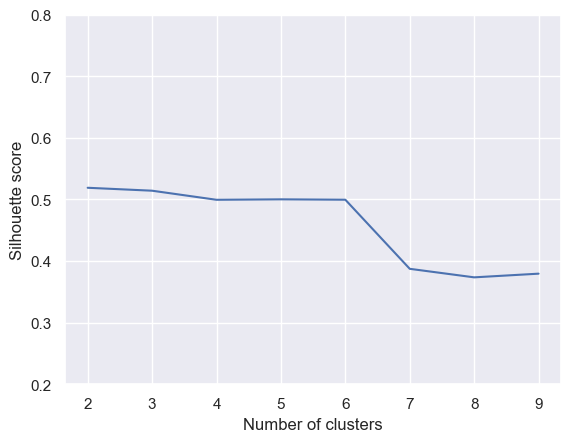

In [2]:
notna_data = train_data.dropna(subset='engine_power_kw')
num_notna_data = notna_data[['mass_kg', 'engine_size_cm3', 'engine_power_kw']]

kmeans = Pipeline([
    ('scaler', StandardScaler()),
    ('clusterer', KMeans(init='k-means++', random_state=0))
])

scores = []
for k in range(2, 10):
    kmeans.set_params(clusterer__n_clusters=k).fit(num_notna_data)
    score = silhouette_score(kmeans['scaler'].transform(num_notna_data),
                             kmeans['clusterer'].labels_,
                             sample_size=40000, random_state=0)
    print(f"For k = {k} the average silhouette score is {score}")
    scores.append(score)

sns.lineplot(x=range(2, 10), y=scores)
plt.ylim(0.2, 0.8)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score");

The best score is for $k = 2$, but clustering this way is not very useful. We choose $k = 6$ as the best compromise. Let's print a few samples and try to identify the vehicle class of each cluster.

In [3]:
kmeans.set_params(clusterer__n_clusters=6).fit(num_notna_data)
for i in range(6):
    display(notna_data[kmeans['clusterer'].labels_ == i].sample(5, random_state=123))

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
132594801,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI,COLT,1195.0,petrol,M,999.0,67.0,132,5.3
132276865,VOLKSWAGEN,VOLKSWAGEN,TAIGO,1255.0,petrol,M,999.0,81.0,207,5.9
123696644,RENAULT-NISSAN-MITSUBISHI,DACIA,SANDERO,1171.0,petrol,M,999.0,67.0,132,5.6
129122423,KIA,KIA,PICANTO,978.0,petrol,M,998.0,49.0,93,5.1
122212617,RENAULT-NISSAN-MITSUBISHI,RENAULT,CAPTUR,1332.0,lpg,B,999.0,67.0,132,7.7


,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
134350908,VOLKSWAGEN,VOLKSWAGEN,T-ROC,1345.0,petrol,M,1498.0,110.0,211,6.0
131869496,STELLANTIS,PEUGEOT,2008,1280.0,petrol,M,1199.0,114.0,160,6.3
121640933,RENAULT-NISSAN-MITSUBISHI,DACIA,DUSTER,1342.0,petrol,M,1332.0,110.0,136,6.2
133354261,KIA,KIA,SPORTAGE,1526.0,petrol,M,1598.0,110.0,99,6.8
134288373,RENAULT-NISSAN-MITSUBISHI,RENAULT,KANGOO,1550.0,petrol,M,1332.0,96.0,136,6.9


,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
132933626,BMW,BMW,Z4 M40I,1640.0,petrol,M,2998.0,250.0,10,8.1
132362397,VOLKSWAGEN,AUDI,RS Q3 SPORTBACK,1775.0,petrol,M,2480.0,294.0,222,10.1
131764255,VOLKSWAGEN,AUDI,RS4 AVANT,1820.0,petrol,M,2894.0,331.0,224,9.9
133511814,BMW,BMW,Z4 M40I,1640.0,petrol,M,2998.0,250.0,10,7.0
133197159,STELLANTIS,MASERATI,GRECALE TROFEO,2102.0,petrol,M,2992.0,390.0,185,11.2


,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
130705486,MERCEDES-BENZ AG,MERCEDES-BENZ,V-KLASSE,2220.0,diesel,M,1950.0,174.0,117,8.4
122244630,RENAULT-NISSAN-MITSUBISHI,RENAULT,TRAFIC,2133.0,diesel,M,1997.0,110.0,142,7.3
132334405,KIA,KIA,SORENTO,1909.0,diesel,M,2151.0,142.0,100,6.6
130734118,STELLANTIS,OPEL,ZAFIRA LIFE,2069.0,diesel,M,1997.0,130.0,177,7.4
131565300,FORD,FORD,TOURNEO CUSTOM,2529.0,diesel,M,1995.0,125.0,38,8.7


,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
121530311,MERCEDES-BENZ AG,MERCEDES-AMG,AMG SL 63 4MATIC+,1970.0,petrol,M,3982.0,430.0,125,13.0
131447271,FORD,FORD,MUSTANG,1893.0,petrol,M,5038.0,330.0,44,11.5
132750506,BMW,BMW,X6 M COMPETITION,2395.0,petrol,M,4395.0,460.0,11,13.4
122959789,FERRARI,FERRARI,F8 SPIDER,1675.0,petrol,M,3902.0,530.0,27,13.0
131303866,GENERAL MOTORS,CHEVROLET,CORVETTE,1767.0,petrol,M,6162.0,354.0,55,12.1


,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
122444256,MERCEDES-BENZ AG,MERCEDES-BENZ,GLA 200 D,1660.0,diesel,M,1950.0,110.0,117,5.5
128525539,MERCEDES-BENZ AG,MERCEDES-BENZ,GLA 180 D,1660.0,diesel,M,1950.0,85.0,117,5.4
132302756,MERCEDES-BENZ AG,MERCEDES-BENZ,CLA 250,1545.0,petrol,M,1991.0,165.0,118,7.4
132237540,BMW,BMW,318I,1575.0,petrol,M,1998.0,115.0,7,6.5
115981656,FORD,FORD,KUGA,1735.0,diesel,M,1995.0,140.0,38,5.9


There is clearly some overlap, but we roughly identify the clusters as follows (please note the zero-indexing):

- **cluster 0**: small cars, cheap larger cars;
- **cluster 1**: compact cars, crossovers;
- **cluster 5**: powerful compact cars, powerful crossovers;
- **cluster 3**: vans, SUVs, compact executive cars;
- **cluster 2**: powerful SUVs, powerful executive cars, sports cars;
- **cluster 4**: luxury cars, supercars.

We relabel these clusters as **small**, **compact**, **premium**, **large**, **performance** and **luxury** respectively. We now compute some summary statistics for each cluster. Note that the coordinates of the cluster centers can be read from the `mean` columns of the table below.

In [4]:
label_map = {0: "small", 1: "compact", 5: "premium", 3: "large", 2: "performance", 4: "luxury"}
labels = [label_map[label] for label in kmeans['clusterer'].labels_]

num_cols = ['mass_kg', 'engine_size_cm3', 'engine_power_kw', 'fuel_cons_l_100km']
notna_data[num_cols].groupby(labels).describe().loc[label_map.values()]

mass_kg                                                   \
                 count         mean         std     min     25%     50%   
small        2287658.0  1189.825320   96.649060   570.0  1147.0  1190.0   
compact      1426569.0  1429.373966  104.800164   700.0  1353.0  1415.0   
premium       254944.0  1602.661259  131.103274  1143.0  1530.0  1620.0   
large          94937.0  2199.241855  174.626894  1901.0  2056.0  2152.0   
performance    59315.0  1791.819759  165.804009  1007.0  1650.0  1765.0   
luxury         24391.0  1870.476241  265.223132  1442.0  1715.0  1862.0   

                            engine_size_cm3                                   \
                75%     max           count         mean         std     min   
small        1263.0  1429.0       2287658.0  1080.085981  124.444205   658.0   
compact      1505.0  1811.0       1426569.0  1436.737615  129.439970   998.0   
premium      1675.0  1910.0        254944.0  1998.602572  121.349796  1199.0   
large        2302.0  4042.0         94937.0  1990.569146  115.986216  1195.0   
performance  1940.0  3088.0         59315.0  2857.285459  348.104578   998.0   
luxury       2005.0  4255.0         24391.0  4437.415358  766.667970  2992.0   

                                            engine_power_kw              \
                25%     50%     75%     max           count        mean   
small         999.0   999.0  1199.0  1999.0       2287658.0   71.186313   
compact      1332.0  1498.0  1499.0  1999.0       1426569.0  101.771855   
premium      1950.0  1995.0  1998.0  5038.0        254944.0  131.823577   
large        1950.0  1995.0  1997.0  2996.0         94937.0  126.605391   
performance  2894.0  2981.0  2993.0  5038.0         59315.0  314.205614   
luxury       3982.0  3996.0  5000.0  7993.0         24391.0  415.380386   

                                                          fuel_cons_l_100km  \
                   std   min    25%    50%    75%     max             count   
small        11.684601   8.0   67.0   70.0   81.0   184.0         2287658.0   
compact      12.347009  11.0   96.0  100.0  110.0   320.0         1426569.0   
premium      35.485084  13.0  110.0  128.0  142.0   294.0          254944.0   
large        28.160138  49.0  110.0  120.0  140.0   280.0           94937.0   
performance  42.037824  90.0  283.0  309.0  353.0   585.0           59315.0   
luxury       60.982010  68.0  375.0  404.0  460.0  1177.0           24391.0   

                                                               
                  mean       std  min   25%   50%   75%   max  
small         5.689307  0.713911  2.9   5.3   5.5   5.9   7.9  
compact       6.056392  0.664954  3.5   5.6   6.1   6.5  10.5  
premium       6.179397  1.066846  3.7   5.2   5.9   6.9  13.7  
large         7.867534  0.835949  4.4   7.3   7.8   8.4  16.1  
performance   9.997523  1.086668  4.3   9.1  10.2  10.9  13.4  
luxury       12.534308  1.262369  6.4  11.6  12.5  13.2  25.2

Finally, we display the different clusters in a scatter plot after reducing their dimensionality with principal component analysis.

Principal components:
[[ 0.5354802   0.60580827  0.58843631]
 [ 0.83374613 -0.2681177  -0.48268032]]


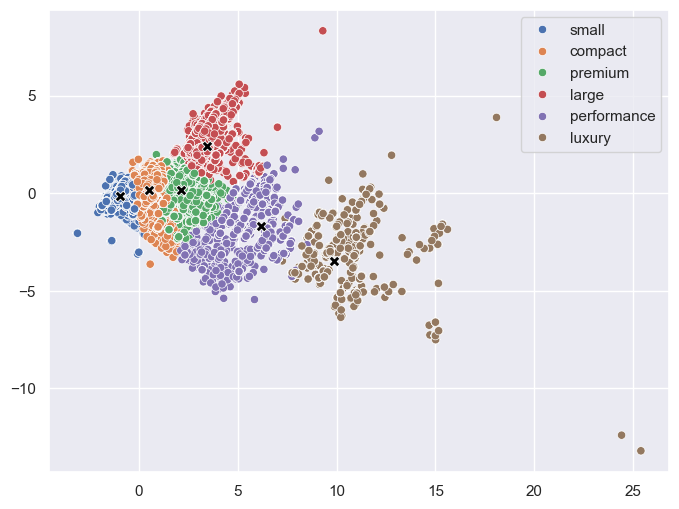

In [5]:
pca = PCA(n_components=2, svd_solver='covariance_eigh').set_output(transform='default')
data_2d = pca.fit_transform(kmeans['scaler'].transform(num_notna_data).to_numpy())
centroids_2d = pca.transform(kmeans['clusterer'].cluster_centers_)
print(f"Principal components:\n{pca.components_}")

plt.subplots(figsize=[8, 6])
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=labels, hue_order=label_map.values())
sns.scatterplot(x=centroids_2d[:, 0], y=centroids_2d[:, 1], s=60, c='black', marker='X');

Except for luxury vehicles that are more clearly separated from the rest, we see significant overlap between the classes. Nevertheless, the trend from small to luxury cars makes intuitive sense, except possibly for the large class which shows higher values of the second principal component.

To explain this, we notice that the first principal component represents the size of the car considering both vehicle mass and engine size, while the second principal component represents how much a car is underpowered, in the sense that it is higher for heavy cars with a relatively small engine.

In this regard, it makes sense that the large class shows a higher second component then the others: the vehicles here contained are mostly vans and cheaper SUVs, that have less power than the other SUVs found on the performance class. Indeed, the summary statistics that we have just computed confirm that the large class has, on average, a greater mass than premium and performance vehicles, but at the same time a smaller engine.

## Regression

For supervised learning we use linear models, because they scale well with the number of samples and they are very easily interpretable. The exploratory data analysis of the previous notebook suggested that the data is at least partially nonlinear, hence we don't expect to obtain exceptionally high scores, but that is not strictly necessary considering the main aim of the project.

We construct a pipeline that imputes NULL values, computes and standardizes higher-order variables, encodes categorical variables, and finally fits the regressor. Since we start with a very limited number of features, we believe that the standard linear regression model may work well. However, our exploratory data analysis has also shown a significant level of collinearity between the features, which might end up having a negative effect on the model stability, especially when coupled with feature engineering techniques. Thus, we will evaluate whether regularization has a positive impact by training the ridge regressor alongside the standard linear regressor. On the other hand, the imputation strategy will surely have a negligible impact on the overall score due to the very small number of NULL values in the data. Hence, we will determine the best strategy at a later moment.

The best hyperparameters will be determined with exhaustive grid search. While it would be ideal to specify the entire grid at the beginning and to evaluate the score with nested cross-validation, this is computationally not feasible for a standard workstation like the one we are using at this moment. Hence, we will iteratively change the grid to explore different parameters, evaluating their scores at each iteration. Potentially optimistic biases that we might produce with this training procedure are mitigated by the fact that the final evaluation will be conducted on the test set, which has already been set aside and it will therefore contain entirely unseen data.

For model evaluation, we consider two metrics, the coefficient of determination R2 and the root mean squared error RMSE. It is evident from their mathematical formulation that the two are equivalent, in the sense that a model is better than another according to the first metric if and only if it is also better according to the second metric:

$$ R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \widehat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}, \qquad \operatorname{RMSE} = \sqrt{\frac{1}{n}\textstyle\sum_{i=1}^n (y_i - \widehat{y}_i)^2}. $$

The advantage of R2 is that it gives a score from 0 to 1, where 1 is the best possible score (actually, negative values of R2 can also occur for particularly bad models). The advantage of RMSE is that it's in the same units of measure of the target variable, hence it effectively indicates how much, on average, the predicted values are far away from the true values.

In [6]:
num_features = ['mass_kg', 'engine_size_cm3', 'engine_power_kw']
cat_features = ['fuel_type', 'fuel_mode']
X_train = train_data[num_features + cat_features]
y_train = train_data.fuel_cons_l_100km
groups = train_data.engine_group_id
group_kfold = GroupKFold(n_splits=5)

In [7]:
numerical = Pipeline([
    ('imputer', SimpleImputer()),
    ('polynomial', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler())
])
transformer = ColumnTransformer([
    ('numerical', numerical, num_features),
    ('categorical', OneHotEncoder(sparse_output=False), ['fuel_type'])
], verbose_feature_names_out=False)
lm_1 = Pipeline([
    ('transformer', transformer),
    ('regressor', None)
])

hyperparams = [
    {
        'transformer__numerical__polynomial__degree': [1, 2, 3, 4, 5],
        'regressor': [LinearRegression(fit_intercept=False)]
    },
    {
        'transformer__numerical__polynomial__degree': [1, 2, 3, 4, 5],
        'regressor': [Ridge(fit_intercept=False)],
        'regressor__alpha': [0.1, 1, 10]
    }
]
gs_1 = GridSearchCV(lm_1, hyperparams, scoring=['r2', 'neg_root_mean_squared_error'],
                    refit=False, cv=group_kfold, return_train_score=True)
gs_1.fit(X_train, y_train, groups=groups)

GridSearchCV(cv=GroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('polynomial',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['mass_kg',
                                                                          'engine_size_cm3',
                                                                          'engine_power_kw']),
                                                                        ('categorical',
                                                                         O...
                                       ('regressor', None)]),
             param_grid=[{'regressor': [LinearRegression(fit_intercept=False)],
                          'transformer__numerical__polynomial__degree': [1, 2,
                                                                         3, 4,
                                                                         5]},
                         {'regressor': [Ridge(fit_intercept=False)],
                          'regressor__alpha': [0.1, 1, 10],
                          'transformer__numerical__polynomial__degree': [1, 2,
                                                                         3, 4,
                                                                         5]}],
             refit=False, return_train_score=True,
             scoring=['r2', 'neg_root_mean_squared_error'])

In [8]:
pd.DataFrame(gs_1.cv_results_)[[
    'rank_test_r2', 'rank_test_neg_root_mean_squared_error',
    'param_transformer__numerical__polynomial__degree', 'param_regressor__alpha',
    'mean_test_r2', 'mean_test_neg_root_mean_squared_error',
    'std_test_r2', 'std_test_neg_root_mean_squared_error', 'mean_train_r2', 'std_train_r2'
]].sort_values('rank_test_r2').style.hide()

rank_test_r2,rank_test_neg_root_mean_squared_error,param_transformer__numerical__polynomial__degree,param_regressor__alpha,mean_test_r2,mean_test_neg_root_mean_squared_error,std_test_r2,std_test_neg_root_mean_squared_error,mean_train_r2,std_train_r2
1,1,3,nan,0.778362,-0.395687,0.162153,0.056465,0.905116,0.009467
2,2,3,0.100000,0.777397,-0.396669,0.161885,0.055876,0.905116,0.009466
3,3,3,1.000000,0.768729,-0.404961,0.160515,0.053606,0.905115,0.009467
4,4,2,nan,0.767663,-0.406374,0.168416,0.063446,0.892727,0.009864
5,5,2,0.100000,0.766662,-0.407396,0.168087,0.062731,0.892727,0.009864
6,6,2,1.000000,0.757792,-0.415910,0.166179,0.059172,0.892727,0.009864
7,7,4,1.000000,0.753478,-0.424559,0.156371,0.064488,0.909466,0.010389
8,8,3,10.000000,0.741699,-0.426823,0.167823,0.069644,0.905058,0.009476
9,9,4,10.000000,0.738782,-0.430653,0.166733,0.071673,0.908711,0.010420
10,10,2,10.000000,0.730050,-0.438556,0.171619,0.071079,0.892726,0.009863


The rankings given by the two metrics are not exactly identical, as they differ on the 13th and 14th place. Actually, within each cross-validation split the two metrics are equivalent and they rank the models in the same way, but the final rank is based on the average of the scores of all splits, which sometimes leads to different rankings.

Linear regression seems to perform slightly better than ridge regression up to the third polynomial degree, probably due to the fact that the number of features is still fairly limited in these cases. On the other hand, linear regression displays evident overfitting for the fifth polynomial degree. Overall, the best polynomial degree appears to be the third ($R^2 = 0.7784$ and $\operatorname{RMSE} = 0.3957$), closely followed by the second ($R^2 = 0.7677$ and $\operatorname{RMSE} = 0.4064$). The first and fourth degree are next, in different orders depending on the scoring metric.

Considering the higher computational cost and risk of overfitting of the third degree, the small score gain over the second degree doesn't seem particularly appealing. Moreover, the standard deviation of the test scores is not negligible, indicating that the training might be a bit unstable. While this is probably determined by our conservative splitting strategy (see the previous notebook for details), it is still a good reason to be cautious and prefer a simpler model. Finally, the second degree model is also easier to interpret, and its predictions may even be computed with pen and paper (and enough motivation). We thus settle for the latter, unless we can significantly improve the score later on.

Let's now evaluate how the model behaves when one-hot encoding the fuel mode in addition to the fuel type.

In [9]:
transformer = ColumnTransformer([
    ('numerical', clone(numerical), num_features),
    ('categorical', OneHotEncoder(sparse_output=False), ['fuel_type', 'fuel_mode'])
], verbose_feature_names_out=False)
lm_2 = clone(lm_1).set_params(transformer=transformer)

hyperparams = [
    {
        'transformer__numerical__polynomial__degree': [2, 3, 4],
        'regressor': [LinearRegression(fit_intercept=False)]
    },
    {
        'transformer__numerical__polynomial__degree': [2, 3, 4],
        'regressor': [Ridge(fit_intercept=False)],
        'regressor__alpha': [0.1, 1, 10]
    }
]
gs_2 = GridSearchCV(lm_2, hyperparams, scoring=['r2', 'neg_root_mean_squared_error'],
                    refit=False, cv=group_kfold, return_train_score=True)
gs_2.fit(X_train, y_train, groups=groups)

pd.DataFrame(gs_2.cv_results_)[[
    'rank_test_r2', 'rank_test_neg_root_mean_squared_error',
    'param_transformer__numerical__polynomial__degree', 'param_regressor__alpha',
    'mean_test_r2', 'mean_test_neg_root_mean_squared_error',
    'std_test_r2', 'std_test_neg_root_mean_squared_error', 'mean_train_r2', 'std_train_r2'
]].sort_values('rank_test_r2').style.hide()

rank_test_r2,rank_test_neg_root_mean_squared_error,param_transformer__numerical__polynomial__degree,param_regressor__alpha,mean_test_r2,mean_test_neg_root_mean_squared_error,std_test_r2,std_test_neg_root_mean_squared_error,mean_train_r2,std_train_r2
1,1,3,nan,0.778346,-0.395738,0.162133,0.056565,0.905139,0.009459
2,2,3,0.100000,0.777874,-0.396220,0.161995,0.056262,0.905139,0.009459
3,3,3,1.000000,0.773418,-0.400614,0.160980,0.054240,0.905138,0.009459
4,4,2,nan,0.767662,-0.406426,0.168397,0.063662,0.892758,0.009851
5,5,2,0.100000,0.767166,-0.406934,0.168231,0.063297,0.892758,0.009851
6,6,2,1.000000,0.762544,-0.411515,0.166948,0.060662,0.892758,0.009851
7,7,4,1.000000,0.758040,-0.420429,0.157000,0.065674,0.909487,0.010381
8,8,3,10.000000,0.749787,-0.420631,0.163939,0.062811,0.905082,0.009468
9,9,4,10.000000,0.747046,-0.424396,0.162457,0.064871,0.908732,0.010413
10,10,2,10.000000,0.738207,-0.432310,0.168364,0.065259,0.892757,0.009851


The scores here are slightly better or slightly worse depending on the parameters, and either way not in a statistically relevant way. This probably means that the fuel mode feature is not very helpful for predicting fuel consumption, as our exploratory data analysis suggested. Even assuming that fuel mode had some positive effects on a subset of the samples, the overall scores being unchanged imply that the scores would have deteriorated for other samples. Hence, we don't think it's helpful to further investigate this path.

At this point, many other feature engineering strategies were tested; it would be impractical to present them all in this notebook, but we list them for completeness: calculated features (such as the power over mass ratio), interactions between categorical and numerical features, transformation of the numerical features into cluster-distance space via k-means (although usually not so helpful in linear models), dimensionality reduction via PCA, target transformations (both logarithmic and quantile). Moreover, other regression models have been tested, among which: lasso, elastic-net, gradient descent, gradient boosting, support vector machines.

Unfortunately, none of these led to an improved model. Indeed, in most cases the overall score was either statistically equal to or worse than the current one. In a few cases, the models were computationally too expensive or were taking too much time to converge.

We finally display the regression coefficients to determine which variables are most relevant in our model. Since we have scaled the data before fitting the regressor, the weights of the coefficients can be compared directly. For this task we also consider the model of the first degree, as higher-order interpolation increases the number of features making their effect less comprehensible.

Coefficients for degree = 1:
[0.53312795 0.16367399 0.42278567 4.70573389 5.95207952 7.83116203
 5.94305565 6.09135351]
Coefficients for degree = 2:
[-0.18342473  0.84425199 -0.07187435  1.39923335 -1.74456719  0.29738039
  0.24082508  0.49360503  0.04103757  4.74911028  5.89684916  7.7472184
  5.96237526  6.08996354]


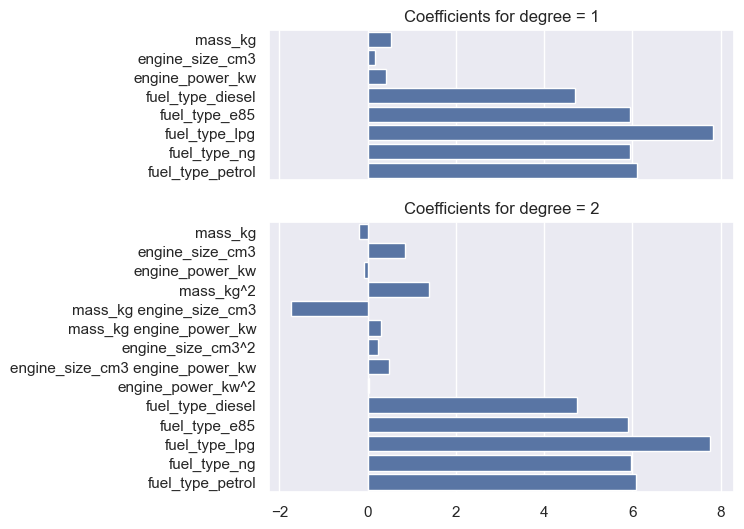

In [10]:
lm_1.set_params(regressor=LinearRegression(fit_intercept=False))

fig, ax = plt.subplots(2, sharex=True, height_ratios=[1, 1.8], figsize=[6, 6])
for index, degree in enumerate([1, 2]):
    lm_1.set_params(transformer__numerical__polynomial__degree=degree)
    lm_1.fit(X_train, y_train)
    print(f"Coefficients for degree = {degree}:\n{lm_1['regressor'].coef_}")
    sns.barplot(x=lm_1['regressor'].coef_, y=lm_1['regressor'].feature_names_in_, ax=ax[index])
    ax[index].set_title(f"Coefficients for degree = {degree}")

The coefficients of the first degree model are all positive despite the collinearity of the features. Still, field knowledge suggests that engine size and power are strictly related, and some weight might happen to be variably distributed among the two depending on the model parameters. The quadratic terms of the second degree model are harder to interpret, but most of them still seem to have an influence on the overall model. The fuel type coefficients are always very large, but that's simply due to the fact that they act as intercepts.

## Fine Tuning

We conclude the hyperparameter tuning phase by choosing the imputation strategy. Let's start by comparing the mean and median imputation strategies in our model.

In [11]:
for strategy in ['mean', 'median']:
    lm_1.set_params(transformer__numerical__imputer__strategy=strategy)
    score = cross_val_score(lm_1, X_train, y_train, groups=groups,
                            scoring='r2', cv=group_kfold).mean()
    print(f"R2 score imputing with the {strategy}: {score}")

R2 score imputing with the mean: 0.7676630216212377
R2 score imputing with the median: 0.7676226995589769


As expected, the imputation strategy is almost irrelevant on the overall score, because the vast majority of the records don't have a NULL engine power. Hence, we now evaluate the R2 score restricted to those that do.

In [12]:
def r2_null_power(estimator, X, y):
    null_power = X.engine_power_kw.isna()
    return r2_score(y[null_power], estimator.predict(X[null_power]))


for strategy in ['mean', 'median']:
    lm_1.set_params(transformer__numerical__imputer__strategy=strategy)
    score = cross_val_score(lm_1, X_train, y_train, groups=groups,
                            scoring=r2_null_power, cv=group_kfold).mean()
    print(f"R2 score for records with NULL power imputing with the {strategy}: {score}")

R2 score for records with NULL power imputing with the mean: 0.20392783524414987
R2 score for records with NULL power imputing with the median: 0.18179884479481379


The mean imputation strategy performs a bit better than the median. However, both scores are quite low, and we would like to improve them. With `SimpleImputer`, engine power is always imputed with the same value, the overall mean or median of the entire dataset. Our idea is to group similar vehicles together, and then impute engine power using the mean of the group. Since we've already dealt with k-means clustering in this notebook, we will also use it here to determine the groups.

As of today, no scikit-learn estimator allows to implement the imputation strategy we have just described. The `KNNImputer` does something similar by imputing missing values with estimates computed from the nearest neighbors; however, the computational cost of nearest neighbors algorithms is just too high for the size of our dataset. Thus, we need to define a custom transformer.

We follow the [scikit-learn developer guidelines](https://scikit-learn.org/stable/developers/develop.html), so that our transformer is automatically compatible with the rest of the scikit-learn API, and in particular with cross-validation classes and functions. For future reusability and for the sake of writing good code, we aim for a slightly higher generality than what we actually need right now, as described in the class docstring below.

In [13]:
class ClusteringImputer(TransformerMixin, OneToOneFeatureMixin, BaseEstimator):
    """Multivariate imputer that uses estimates based on aggregate data.

    It roughly behaves as SimpleImputer, but the data is aggregated via a
    clustering model before computing the estimates of the fill values. For
    each feature, the clusterer is fit on the other features, then the data
    is grouped according to the cluster labels and the estimates are
    computed using the requested strategy. For samples in which more than
    one feature is missing, the fitted clusterer cannot be applied and a
    fallback imputer is used.

    Parameters
    ----------
    clusterer : estimator object, default=KMeans()
        The clusterer to use for each set of input features.
    strategy : function or str, default='mean'
        The imputation strategy. Must work with `pandas.Series.agg`.
    fallback : estimator object, default=SimpleImputer()
        The fallback imputer to use when clustering cannot be applied.

    Attributes
    ----------
    fallback_imputer_ : estimator object
        The fitted fallback imputer.
    clustering_imputers_ : list of tuples
        Each tuple has `(feat_idx, clusterer, agg_values)`, where `feat_idx`
        is the index of the feature to be imputed, `clusterer` is the
        clusterer fitted on the other features, and `agg_values` is a
        dictionary that maps the cluster labels to the computed fill values.
    """

    def __init__(self, clusterer=None, *, strategy='mean', fallback=None):
        self.clusterer = clusterer
        self.strategy = strategy
        self.fallback = fallback

    def fit(self, X, y=None):
        if self.clusterer is not None and not is_clusterer(self.clusterer):
            raise ValueError("a clustering estimator must be provided")
        X = validate_data(self, X, dtype=[np.float64, np.float32],
                          ensure_all_finite='allow-nan', ensure_min_features=2)

        self.fallback_imputer_ = (
            clone(self.fallback) if self.fallback is not None else SimpleImputer()
        )
        self.fallback_imputer_.fit(X)

        self.clustering_imputers_ = []
        X = X[~np.isnan(X).any(axis=1)]
        if X.size == 0:
            warnings.warn(
                "all the samples have at least one empty feature, hence "
                "no clustering imputer can be fitted and the fallback "
                "imputer will always be used for transforming the input",
                FitFailedWarning
            )
            return self
        for feat_idx in range(self.n_features_in_):
            clusterer = clone(self.clusterer) if self.clusterer is not None else KMeans()
            labels = clusterer.fit_predict(np.delete(X, feat_idx, axis=1))
            agg_values = pd.Series(X[:, feat_idx]).groupby(labels).agg(self.strategy).to_dict()
            self.clustering_imputers_.append((feat_idx, clusterer, agg_values))

        return self

    def transform(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, reset=False, dtype=[np.float64, np.float32],
                          copy=True, force_writeable=True, ensure_all_finite='allow-nan')

        fallback_rows = np.isnan(X).sum(axis=1) > 1
        if fallback_rows.any():
            X[fallback_rows] = self.fallback_imputer_.transform(X[fallback_rows])

        for feat_idx, clusterer, agg_values in self.clustering_imputers_:
            na_feat_rows = np.isnan(X[:, feat_idx])
            if not na_feat_rows.any():
                continue
            labels = clusterer.predict(np.delete(X[na_feat_rows], feat_idx, axis=1))
            values = np.empty_like(labels)
            for cluster_idx, agg_value in agg_values.items():
                values[labels == cluster_idx] = agg_value
            X[na_feat_rows, feat_idx] = values

        return X

We now modify our original pipeline by substituting the simple imputer with our custom imputer. Then, we perform grid search to determine the best number of clusters.

In [14]:
lm_3 = clone(lm_1).set_params(transformer__numerical__imputer=ClusteringImputer(kmeans))

hyperparams = {
    'transformer__numerical__imputer__clusterer__clusterer__n_clusters': range(2, 10)
}
gs_3 = GridSearchCV(lm_3, hyperparams, scoring=r2_null_power, cv=group_kfold)
gs_3.fit(X_train, y_train, groups=groups)

GridSearchCV(cv=GroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          ClusteringImputer(clusterer=Pipeline(steps=[('scaler',
                                                                                                                                       StandardScaler()),
                                                                                                                                      ('clusterer',
                                                                                                                                       KMeans(n_clusters=6,
                                                                                                                                              random_state=0))]))),
                                                                                         ('polynomial',
                                                                                          PolynomialFeatures(include...
                                                                                          StandardScaler())]),
                                                                         ['mass_kg',
                                                                          'engine_size_cm3',
                                                                          'engine_power_kw']),
                                                                        ('categorical',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['fuel_type'])],
                                                          verbose_feature_names_out=False)),
                                       ('regressor',
                                        LinearRegression(fit_intercept=False))]),
             param_grid={'transformer__numerical__imputer__clusterer__clusterer__n_clusters': range(2, 10)},
             scoring=<function r2_null_power at 0x00000185A75EEA20>)

In [15]:
pd.DataFrame(gs_3.cv_results_)[[
    'rank_test_score',
    'param_transformer__numerical__imputer__clusterer__clusterer__n_clusters',
    'mean_test_score',
    'std_test_score'
]].sort_values('rank_test_score').style.hide()

rank_test_score,param_transformer__numerical__imputer__clusterer__clusterer__n_clusters,mean_test_score,std_test_score
1,6,0.566355,0.320636
2,8,0.556335,0.311653
3,9,0.548755,0.303339
4,7,0.526936,0.330629
5,5,0.503463,0.294219
6,4,0.484915,0.289574
7,3,0.380162,0.238492
8,2,0.328673,0.296861


Interestingly, the best R2 score is obtained with `n_clusters=6`, which is the same number of clusters that we had chosen heuristically when performing unsupervised learning: our initial choice is thus reaffirmed by these results. The score on the records with NULL engine power is $R^2 = 0.5664$, which is remarkably higher than the score we had with the simple imputer.

Since this is our final model, let's extract it from the grid search instance and recompute the overall scores (on all records) to make sure they are coherent with the ones we had obtained previously. (Since the cross-validation functions in scikit-learn always clone the estimator, passing it directly in input is not an issue). We also compare the coefficients of the latest model with the ones of the original model.

In [16]:
linear = gs_3.best_estimator_

scores = cross_validate(linear, X_train, y_train, groups=groups,
                        scoring=['r2', 'neg_root_mean_squared_error'], cv=group_kfold)
print(f"R2 score with custom imputer: {scores['test_r2'].mean()}\n"
      f"RMSE with custom imputer: {-scores['test_neg_root_mean_squared_error'].mean()}")

R2 score with custom imputer: 0.7678302529218808
RMSE with custom imputer: 0.40591790033471575


Coefficients:
[-0.18637335  0.84699367 -0.07248744  1.40249564 -1.74459997  0.29437675
  0.21658555  0.53820444  0.01970496  4.75135118  5.89628808  7.74694725
  5.96267022  6.08957792]


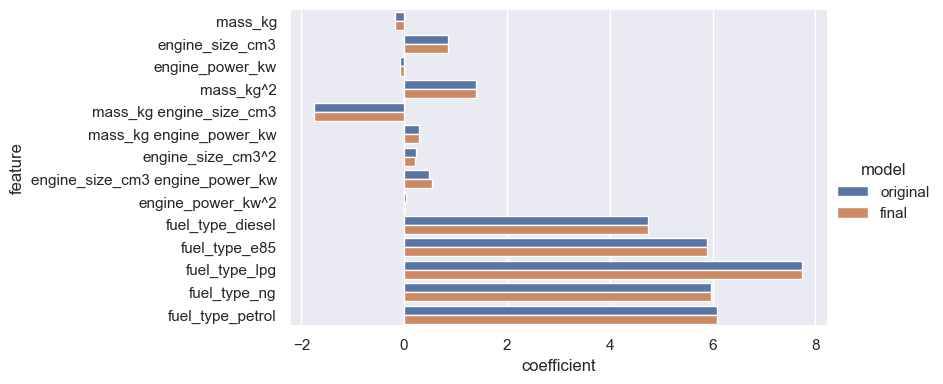

In [17]:
print(f"Coefficients:\n{linear['regressor'].coef_}")
orig_coef = pd.DataFrame({'feature': lm_1['regressor'].feature_names_in_,
                          'coefficient': lm_1['regressor'].coef_, 'model': 'original'})
final_coef = pd.DataFrame({'feature': linear['regressor'].feature_names_in_,
                           'coefficient': linear['regressor'].coef_, 'model': 'final'})
all_coef = pd.concat([orig_coef, final_coef])
sns.catplot(all_coef, x='coefficient', y='feature', hue='model', kind='bar', height=4, aspect=2.2);

The coefficients of the final linear model are very close to those of the original model, and there is no statistically relevant difference in the final R2 and RMSE scores. This is consistent with the fact that the vast majority of the records don't have missing values, and it confirms that our new model performs at least as good as the original one on the others.

## Final Evaluation

We now evaluate the performance of our final model on the held-out test set.

In [18]:
test_data = pd.read_parquet("../data/test.parquet")
display(test_data.sample(5, random_state=123))

X_test = test_data[num_features + cat_features]
y_test = test_data.fuel_cons_l_100km

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
129741836,VOLKSWAGEN,SEAT,SEAT LEON,1416.0,diesel,M,1968.0,85.0,218,4.3
132532898,VOLKSWAGEN,SKODA,SUPERB,1580.0,petrol,M,1984.0,140.0,219,7.2
129956271,STELLANTIS,ALFA ROMEO,STELVIO,1820.0,diesel,M,2143.0,154.0,179,6.0
127465496,VOLKSWAGEN,SKODA,OCTAVIA,1427.0,diesel,M,1968.0,85.0,218,4.2
127247669,HYUNDAI MOTOR EUROPE,HYUNDAI,I 30,1291.0,petrol,M,998.0,88.0,61,5.5


In [19]:
y_pred = linear.predict(X_test)
print(f"R2 score: {r2_score(y_test, y_pred)}\n"
      f"RMSE: {root_mean_squared_error(y_test, y_pred)}")

R2 score: 0.8371247434453788
RMSE: 0.5383603034652745


The final scores $R^2 = 0.8371$ and $\operatorname{RMSE} = 0.5384$ are actually a bit different than the ones we had found with cross-validation on the training set. This is probably determined by our conservative splitting strategy which prevents groups of similar vehicles to be separated in different folds (see the previous notebook for details). This imposes strong restrictions on how the data is split, causing some folds to be particularly lucky and others particularly unlucky.

The estimated performance of the model on unseen data is surely not outstanding, but actually not too bad either, especially considering the very limited number of features that we are working with. To give a concrete example, on a typical European car that consumes 6 l/100 km, an additional 0.54 l/100 km is a 9% increase in fuel consumption, and it means that the car will run approximately 1.38 kilometers less for each liter of fuel (15.29 kilometers instead of 16.67). According to the [Weekly Oil Bulletin of the European Commission](https://energy.ec.europa.eu/data-and-analysis/weekly-oil-bulletin_en), the weighted average price of petrol at the end of March 2025 is 1.646 €/l, so that a 9% increase in consumption leads to an additional cost of 89 cents over 100 km (10.76 € instead of 9.88 €).

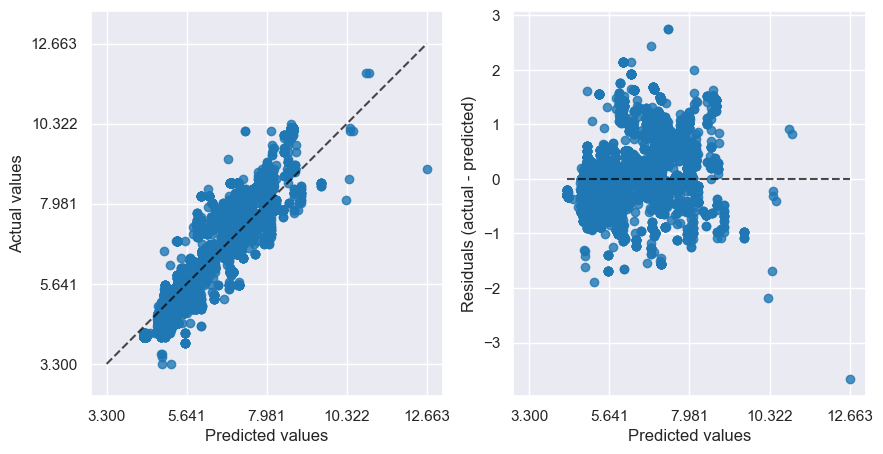

In [20]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=[10, 5])
PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind='actual_vs_predicted', subsample=0.01, random_state=0, ax=ax[0]
).plot(kind='residual_vs_predicted', ax=ax[1]);

Since we have explicitly dealt with engine power imputation, we conclude this section by checking the final scores on the subset of records whose engine power is missing.

In [21]:
null_power = X_test.engine_power_kw.isna()
y_test_np = y_test[null_power]
y_pred_np = linear.predict(X_test[null_power])
print(f"R2 score for records with NULL power: {r2_score(y_test_np, y_pred_np)}\n"
      f"RMSE for records with NULL power: {root_mean_squared_error(y_test_np, y_pred_np)}")

R2 score for records with NULL power: 0.6575670030566605
RMSE for records with NULL power: 0.7303281853146977


## Model Persistence

We conclude this work by persisting our models to disk. Even though they can be reconstructed from their parameters and estimated attributes (which can mostly be read from the code and cell outputs of this notebook), keeping serialized versions is surely more practical. We use skops because it is safer than pickle; make sure to import and trust the necessary objects (including our custom estimator) before calling `sio.load`.

In [22]:
sio.dump(kmeans, "../models/k-means.skops", compression=ZIP_DEFLATED)
sio.dump(linear, "../models/linear-regression.skops", compression=ZIP_DEFLATED)